In [1]:
%load_ext ipydex.displaytools
from sympy import *
import symbtools as st
from IPython.display import display
init_printing()

In [2]:
def row_select(mat, rows):
    return st.row_col_select(mat, list(rows), range(mat.cols))

def translate(x, y, z):
    return Matrix([[1, 0, 0, x],
                   [0, 1, 0, y],
                   [0, 0, 1, z],
                   [0, 0, 0, 1]])

def get_translation(mat):
    return st.row_col_select(mat, [0, 1, 2], [3])

def get_rotation(mat):
    return st.row_col_select(mat, [0, 1, 2], [0, 1, 2])

Zuerst mal alle Symbole definieren

In [3]:
t = Symbol("t")

xc, yc, zc, xf, yf, zf, xb, yb, zb = p = st.symb_vector('x_c y_c z_c x_f y_f z_f x_b y_b z_b')
xcd, ycd, zcd, xfd, yfd, zfd, xbd, ybd, zbd = pd = st.time_deriv(p, p)

pc = row_select(p, range(0, 3))
pf = row_select(p, range(3, 6))
pb = row_select(p, range(6, 9))

phi, eps, lamb = q = st.symb_vector("varphi varepsilon lambda")
phid, epsd, lambd = qd = st.time_deriv(q, q)
phidd, epsdd, lambdd = qdd = st.time_deriv(q, q, order=2)

lc, lh, lp, dc, dh = symbols("l_c, l_h, l_p, d_c, d_h")
mc, mh = symbols("m_c, m_h")
Ffs, Fbs = symbols("F_f, F_b")

g = symbols("g")

Aufstellen der Transformationsmatrizen

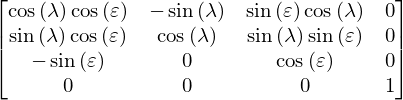

---


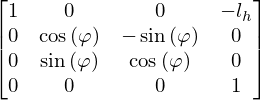

---


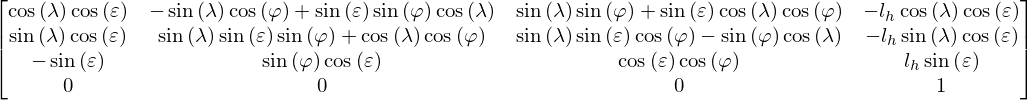

---


In [4]:
rot_phi = Matrix([[1, 0, 0, 0],
                  [0, cos(phi), -sin(phi), 0],
                  [0, sin(phi), cos(phi), 0],
                  [0, 0, 0, 1]])

rot_eps = Matrix([[cos(eps), 0, sin(eps), 0],
                  [0, 1, 0, 0],
                  [-sin(eps), 0, cos(eps), 0],
                  [0, 0, 0, 1]])

rot_lamb = Matrix([[cos(lamb), -sin(lamb), 0, 0],
                   [sin(lamb), cos(lamb), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])

IA = rot_lamb * rot_eps ##:
AH = translate(-lh, 0, 0) * rot_phi ##:
IH = IA * AH ##:

Definition der Transformationsgleichungen für Koordinaten und erste Zeitableitungen

In [5]:
pc_from_q = get_translation(IA * translate(lc, 0, -dc))
pf_from_q = get_translation(IH * translate(0, lp, dh))
pb_from_q = get_translation(IH * translate(0, -lp, dh))

p_from_q = Matrix([pc_from_q[0], pc_from_q[1], pc_from_q[2], pf_from_q[0], pf_from_q[1], pf_from_q[2], pb_from_q[0], pb_from_q[1], pb_from_q[2]])

p_to_q_subs = list(zip(p, p_from_q))

pd_to_qd_subs = list(zip(pd, p_from_q.jacobian(q) * qd))

Langrange-Funktion in redundanten Koordinaten

In [6]:
T = S(1)/S(2)*(mc*(xcd**2+ycd**2+zcd**2)+
               mh/2*(xfd**2+yfd**2+zfd**2)+
               mh/2*(xbd**2+ybd**2+zbd**2))
V = mc*g*zc+mh/2*g*zf+mh/2*g*zb
L_redundant = T - V

Substitution und Darstellung in Minimalkoordinaten

In [7]:
L = L_redundant.subs(p_to_q_subs).subs(pd_to_qd_subs).simplify()

Definition der Rotorkräfte

In [8]:
F_direction_local = Matrix([0, 0, 1])
F_direction = get_rotation(IH) * F_direction_local

Ff = Ffs * F_direction
Fb = Fbs * F_direction

Rotorkräfte in redundanten Koordinaten

In [9]:
F_redundant = st.row_stack(Matrix([0, 0, 0]), Ff, Fb)

Rotorkräfte in Minimalkoordinaten

In [10]:
fp = (F_redundant.T * p_from_q.diff(phi))[0].simplify() ##:
fe = (F_redundant.T * p_from_q.diff(eps))[0].simplify() ##:
fl = (F_redundant.T * p_from_q.diff(lamb))[0].simplify() ##:

---


---


---


Aufstellen der Bewegungsgleichungen

In [11]:
L_d_l = L.diff(lamb).simplify()
L_d_dl = L.diff(lambd).simplify()

L_d_e = L.diff(eps).simplify()
L_d_de = L.diff(epsd).simplify()

L_d_p = L.diff(phi).simplify()
L_d_dp = L.diff(phid).simplify()

erster_term_l = st.time_deriv(L_d_dl, q)
erster_term_e = st.time_deriv(L_d_de, q)
erster_term_p = st.time_deriv(L_d_dp, q)

Eq_l = Eq(erster_term_l - L_d_l, fl)
Eq_e = Eq(erster_term_e - L_d_e, fe)
Eq_p = Eq(erster_term_p - L_d_p, fp)

Transform equations of motion to form $M \ddot q = b$

In [12]:
Eq_p_expanded = Eq(Eq_p.lhs.expand().collect(list(qdd)), Eq_p.rhs)
Eq_e_expanded = Eq(Eq_e.lhs.expand().collect(list(qdd)), Eq_e.rhs)
Eq_l_expanded = Eq(Eq_l.lhs.expand().collect(list(qdd)), Eq_l.rhs)
M, b = linear_eq_to_matrix([Eq_p_expanded, Eq_e_expanded, Eq_l_expanded], list(qdd))
b_no_centripetal = b.subs(list(zip(qd, [0, 0, 0])))
C = -(b - b_no_centripetal)
b_no_gravity = b.subs(g, 0)
G = -(b - b_no_gravity)
f = Matrix([fp, fe, fl])

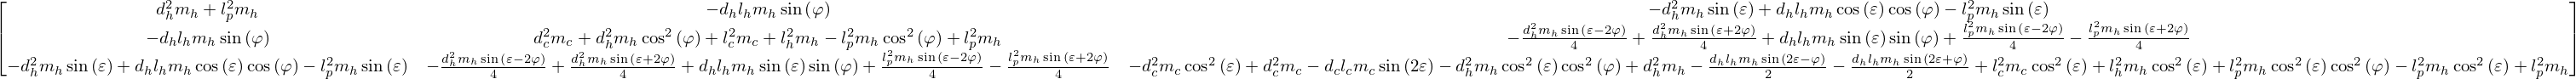

In [13]:
M

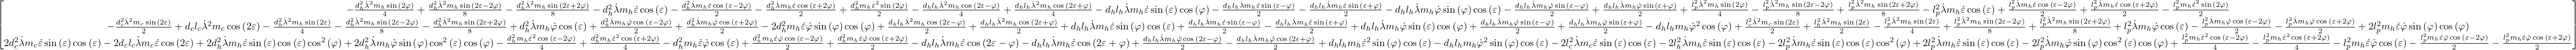

In [14]:
C

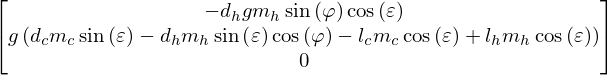

In [15]:
simplify(G)

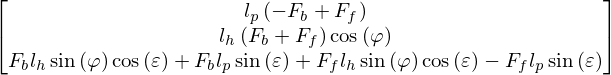

In [16]:
simplify(f)

# Parameter identification?

With $m_h$ and $m_c$

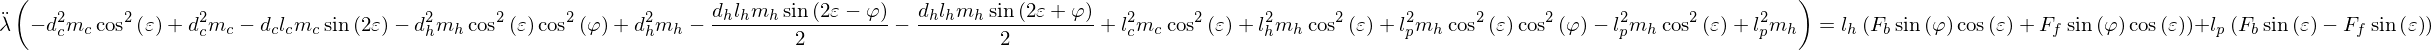

In [40]:
Eq_p_ident_decoupled = Eq(Eq_p.lhs.subs([(edds, 0), (eds, 0), (ldds, 0), (lds, 0)]).simplify().expand().collect([pdds]), Eq_p.rhs)
Eq_e_ident_decoupled = Eq(Eq_e.lhs.subs([(pdds, 0), (pds, 0), (ldds, 0), (lds, 0)]).simplify().expand().collect([edds, sin(es), cos(es)]), Eq_e.rhs)
Eq_l_ident_decoupled = Eq(Eq_l.lhs.subs([(pdds, 0), (pds, 0), (edds, 0), (eds, 0)]).simplify().expand().collect([ldds]), Eq_l.rhs.collect([lp, lh]))

display(Eq_p_ident_decoupled)
display(Eq_e_ident_decoupled)
display(Eq_l_ident_decoupled)

In [48]:
Eq_p_ident = Eq(Eq_p_ident_decoupled.lhs.subs(es, 0), Eq_p_ident_decoupled.rhs)
Eq_e_ident = Eq(Eq_e_ident_decoupled.lhs.subs([(ps, 0)]), Eq_e_ident_decoupled.rhs)
Eq_l_ident = Eq(Eq_l_ident_decoupled.lhs.subs([(ps, 0),(es, 0)]), Eq_l_ident_decoupled.rhs)

display(Eq_p_ident)
display(Eq_e_ident)
display(Eq_l_ident)

In [57]:
p_phi_1, p_phi_2, mu_phi = [Symbol(tex) for tex in [r"p_{\varphi,1}", r"p_{\varphi,2}", r"\mu_\varphi"]]
p_eps_1, p_eps_2, p_eps_3, mu_eps = [Symbol(tex) for tex in [r"p_{\varepsilon,1}", r"p_{\varepsilon,2}", r"p_{\varepsilon,3}", r"\mu_\varepsilon"]]
p_lamb_1, mu_lamb = [Symbol(tex) for tex in [r"p_{\lambda,1}", r"\mu_\lambda"]]

In [58]:
eq_phi_1 = Eq(p_phi_1, dh^2*mh+lp**2*mh)
eq_phi_2 = Eq(p_phi_2, -dh*mh*g)
eq_eps_1 = Eq(p_eps_1, mh*dh**2+mc*dc**2+mc*lc**2+mh*lh**2)
eq_eps_2 = Eq(p_eps_2, g*(mc*dc-mh*dh))
eq_eps_3 = Eq(p_eps_3, g*(mh*lh-mc*lc))
eq_lamb_1 = Eq(p_lamb_1, mc*lc**2+mh*lh**2+mh*lp**2)

In [60]:
sol = solve([eq_eps_1, eq_eps_2, eq_eps_3], [lc, dc, mc])

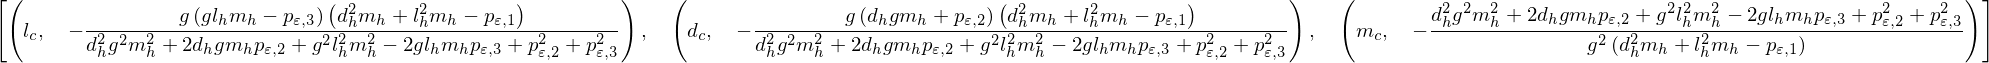

In [65]:
list(zip([lc, dc, mc], sol[0]))

In [66]:
sol = solve([eq_lamb_1, eq_eps_2, eq_eps_3], [lc, dc, mc])

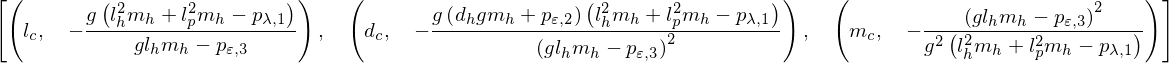

In [68]:
list(zip([lc, dc, mc], sol[0]))

With $m_h$, $m_a$ and $m_c$

In [69]:
ma = Symbol('m_a')

In [71]:
eq_eps_1 = Eq(p_eps_1, mh*dh**2+mc*dc**2+mc*lc**2+mh*lh**2+ma*lh**2)
eq_eps_2 = Eq(p_eps_2, g*(mc*dc-mh*dh))
eq_eps_3 = Eq(p_eps_3, g*((mh+ma)*lh-mc*lc))
eq_lamb_1 = Eq(p_lamb_1, mc*lc**2+mh*lh**2+mh*lp**2+ma*lh**2)

In [74]:
sol = solve([eq_eps_1, eq_eps_2, eq_eps_3, eq_lamb_1], [ma, mc, lc, dc])

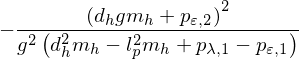

In [83]:
sol[1][1]

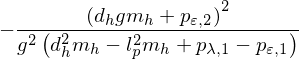

In [84]:
sol[0][1]

In [100]:
sol = solve([eq_eps_3, eq_lamb_1], [ma, lc])

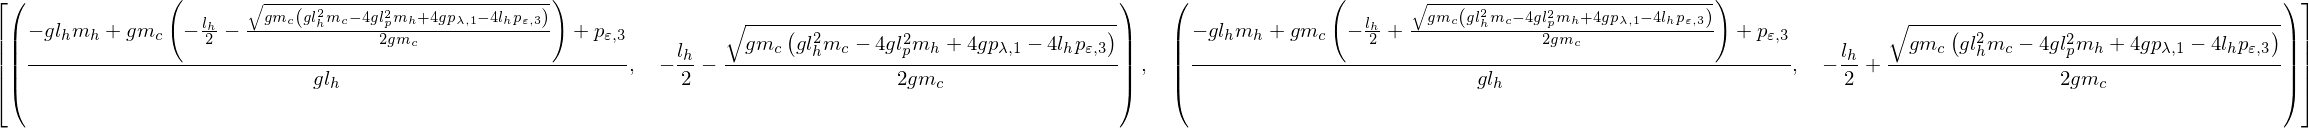

In [101]:
sol

In [95]:
sol = solve(eq_eps_3, ma)

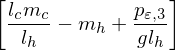

In [96]:
sol

# Simplification justifications

In [33]:
param_symbols = [lh, lc, lp, dc, dh, mh, mc, g]
param_values = [0.66, 0.41, 0.178, 0.07, 0.0027, 1.2, 1.76, 9.81]
param_subs = list(zip(param_symbols, param_values))

deg = pi/180
angle_symbols = list(q)
velo_symbols = list(qd)
acc_symbols = list(qdd)
angle_subs_0 = list(zip(angle_symbols, [0, 0, 0]))
angle_subs_1 = list(zip(angle_symbols, [45*deg, 20*deg, 0]))
angle_subs_2 = list(zip(angle_symbols, [45*deg, 10*deg, 0]))
velo_subs_0 = list(zip(velo_symbols, [0, 0, 0]))
velo_subs_1 = list(zip(velo_symbols, [20*deg, 5*deg, 45*deg]))
velo_subs_2 = list(zip(velo_symbols, [0, 0, 120*deg]))
acc_subs_1 = list(zip(acc_symbols, [0.9, 0.15, 0.4]))

Mass matrix for all angles 0

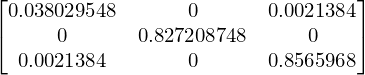

---
\left[\begin{matrix}0.038029548 & 0 & 0.0021384\\0 & 0.827208748 & 0\\0.0021384 & 0 & 0.8565968\end{matrix}\right]


In [18]:
mass_matrix_0 = N(M.subs(param_subs).subs(angle_subs_0)) ##:
print(latex(mass_matrix_0))

Mass matrix for $\varphi=45°$, $\varepsilon=20°$

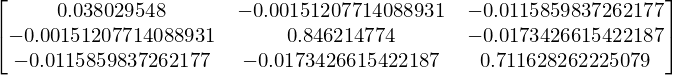

---
\left[\begin{matrix}0.038029548 & -0.00151207714088931 & -0.0115859837262177\\-0.00151207714088931 & 0.846214774 & -0.0173426615422187\\-0.0115859837262177 & -0.0173426615422187 & 0.711628262225079\end{matrix}\right]


In [29]:
mass_matrix_1 = N(M.subs(param_subs).subs(angle_subs_1)) ##:
print(latex(mass_matrix_1))

Mass matrix for $\varphi=45°$, $\varepsilon=10°$

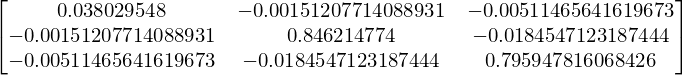

---
\left[\begin{matrix}0.038029548 & -0.00151207714088931 & -0.00511465641619673\\-0.00151207714088931 & 0.846214774 & -0.0184547123187444\\-0.00511465641619673 & -0.0184547123187444 & 0.795947816068426\end{matrix}\right]


In [32]:
mass_matrix_2 = N(M.subs(param_subs).subs(angle_subs_2)) ##:
print(latex(mass_matrix_2))

Magnitude of centripetal forces for $\dot\varphi=20°/s$, $\dot\varepsilon=5°/s$, $\dot\lambda=45°/s$

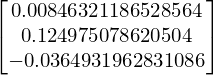

In [30]:
N(C.subs(param_subs).subs(angle_subs_2).subs(velo_subs_1))

Magnitude of centripetal forces for $\dot\lambda=120°/s$

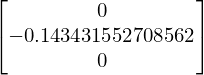

In [22]:
N(C.subs(param_subs).subs([(phi, 0), (eps, -6*deg), (lamb, 0)]).subs(velo_subs_2))

Magnitude of gravity

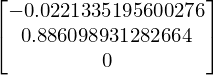

In [31]:
N(G.subs(param_subs).subs(angle_subs_2))

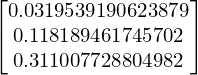

In [37]:
N((M * qdd).subs(param_subs).subs(angle_subs_2).subs(acc_subs_1))

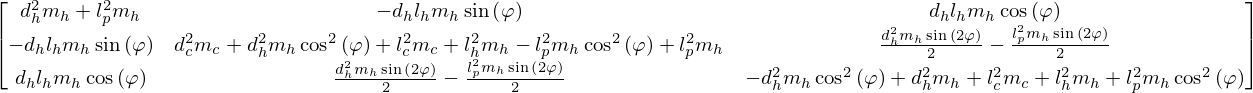

In [39]:
M.subs([(eps, 0)])